This is a 'clean code' version of the [draw_map](./draw_map.ipnb) notebook. The aim is to draw a map showing the number of inhabitants (2014 data) per one public transport (bus, tube or DLR) stop in each of the London wards, which could help answer the question how to improve London's public transport.

In [93]:
import xmltodict
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from pysal.esda.mapclassify import Natural_Breaks as nb
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon 
from shapely.prepared import prep
import pyproj
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from __future__ import unicode_literals
import seaborn as sns

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = (18,18)

We will be using several data sets in the analysis:

1. The map of the London wards (obrained from [here](http://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)). To transform it into the WGS 84 reference system, we transofrm it: `$ ogr2ogr -t_srs EPSG:4326 London_Ward_ESPG4326.shp London_Ward_CityMerged.shp`. The City of London borough has been merged into a single shape here, will require an edit later.

2. The list of London bus stops (from Transport for London (TfL) [website](https://api-portal.tfl.gov.uk/docs)).

3. The list of London tube + DLR stops (also on the TfL website).

4. The estimate data about the inhabitants per ward ([here](http://data.london.gov.uk/dataset/office-national-statistics-ons-population-estimates-borough)).

First, we read in and prepare the data.

In [94]:
# bus stops
busStops = pd.read_csv('data/bus-stops.csv')

# remove the virtual stops that are only for testing
busStops = busStops[busStops['Virtual_Bus_Stop'] == 0]

# the locations for the bus stops are in awkward units, need to transform them
def proj_transform(df):
    # Transforms from British Ordnance survey coords into lon and lat
    # credit: Alberto Negron 
    # http://altons.github.io/python/2012/12/01/converting-northing-and-easting-to-latitude-and-longitude/
    bng = pyproj.Proj(init='epsg:27700')
    wgs84 = pyproj.Proj(init='epsg:4326')
    lon,lat = pyproj.transform(bng,wgs84,list(df['Location_Easting']), list(df['Location_Northing']))
    
    df['lat'] = lat
    df['lon'] = lon
    return df

busStops = proj_transform(busStops)

In [95]:
# tube + DLR stops
# comes as a KML file, so a bit of a hacky way of decoding it

with open('data/stations.kml','r') as f:
    doc = xmltodict.parse(f.read())

tubeNames = []
tubeLats = []
tubeLons = []
    
for pMark in doc['kml']['Document']['Placemark']:
    #the actual data are hidden in 'Placemark's, all of which are OrderedDicts
    tubeNames.append(dict(pMark)['name'])
    #the Point key in pMark contains another OrderedDict with the coord string
    c = [float(num) for num in dict(dict(pMark)['Point'])['coordinates'].split(',')]
    tubeLons.append(c[0])
    tubeLats.append(c[1])

tubeStops = pd.DataFrame({'names': tubeNames, 'lon': tubeLons, 'lat': tubeLats})

Now we can plot the map of London streets with all the stops marked.

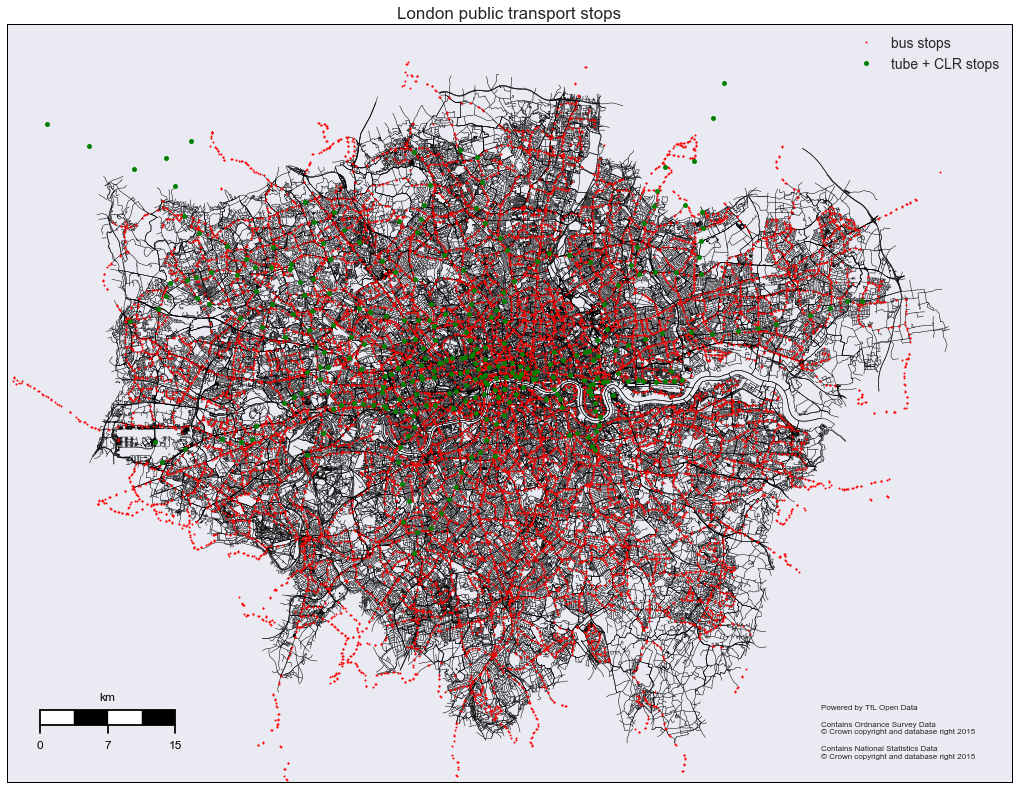

In [96]:
plt.clf()

myMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.6,llcrnrlat=51.26,urcrnrlon=.4,urcrnrlat=51.73)

myMap.drawmapboundary()

#myMap.drawrivers(color='aqua',linewidth=2.)
myMap.drawmapscale(lon=-.5,lat=51.3,lon0=-0.13,lat0=51.51,length=15,barstyle='fancy',fontsize=12)

myMap.readshapefile('data/London-wards-2014_ESRI/London_Ward_ESPG4326','london')
myMap.readshapefile('data/roads','roads')

x,y = myMap(list(busStops['lon']),list(busStops['lat']))
myMap.plot(x,y,'ro',markersize=2,label='bus stops')

x,y = myMap(list(tubeStops['lon']),list(tubeStops['lat']))
myMap.plot(x,y,'go',markersize=5,label='tube + CLR stops')

# copyright notices
x,y = myMap(0.21,51.305)
plt.text(x,y,u'Powered by TfL Open Data', size=8)

x,y = myMap(0.21,51.290)
plt.text(x,y,u'Contains Ordnance Survey Data\n© Crown copyright and database right 2015', size=8)

x,y = myMap(0.21,51.275)
plt.text(x,y,u'Contains National Statistics Data\n© Crown copyright and database right 2015', size=8)

plt.legend(fontsize=14)

plt.title('London public transport stops',fontsize=17)

plt.show()

There are more than 18000 bus and 302 tube stops. The bus stops (red) cover most of the city, while the tube stops are concentrated more toward the centre. 

We now create two 'density' maps: 

* a simple map of density of public transport stops per square kilometer in each individual ward.
* a map of public transport stops per inhabitant in the individual wards. 

In the former case, the areas with higher stop density will presumably offer more choice and better connection. The latter map shows this density normalized by the population density. Presumably, residential areas would need a higher amount of bus stops to take care of all the people.

In [97]:
wards = pd.DataFrame({'name': [n['NAME'] for n in myMap.london_info],
                      'code': [n['GSS_CODE'] for n in myMap.london_info],
                     'areaHa': [float(n['HECTARES']) for n in myMap.london_info],
                     'poly': [Polygon(xy) for xy in myMap.london],
                     'borough': [n['BOROUGH'] for n in myMap.london_info],
                     'nonLand': [float(n['NONLD_AREA']) for n in myMap.london_info]})

In [98]:
wardsPoly = prep(MultiPolygon(list(wards['poly'].values)))

# calculating the bus stop density
busPoints = MultiPoint([Point(myMap(mapX,mapY)) for mapX, mapY in zip(busStops['lon'], busStops['lat'])])
cityStops = filter(wardsPoly.contains,busPoints)

wards['busCount'] = wards['poly'].map(lambda x: int(len(filter(prep(x).contains, cityStops))))
wards['busStopDensity'] = 100*wards['busCount']/(wards['areaHa']-wards['nonLand']) #in stops per sq. km

# calculating the tube stop density
tubePoints = MultiPoint([Point(myMap(mapX,mapY)) for mapX, mapY in zip(tubeStops['lon'], tubeStops['lat'])])
cityTubeStops = filter(wardsPoly.contains,tubePoints)

wards['tubeCount'] = wards['poly'].map(lambda x: int(len(filter(prep(x).contains, cityTubeStops))))
wards['tubeStopDensity'] = 100*wards['tubeCount']/(wards['areaHa']-wards['nonLand']) #in stops per sq. km

# total stop density
wards['count'] = wards['tubeCount']+wards['busCount']
wards['stopDensity'] = 100*wards['count']/(wards['areaHa']-wards['nonLand']) #in stops per sq. km

In [99]:
breaks = nb(wards['stopDensity'].values,initial=500,k=10)
wards['jBins'] = breaks.yb
jLabels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(breaks.bins, breaks.counts)]

cmap = plt.get_cmap('Blues')

wards['patches'] = wards['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))

The colorbar function below comes from [here](http://beneathdata.com/how-to/visualizing-my-location-history/), where a somewhat similar thing is being done like with the sensitivecities.

In [100]:
def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar


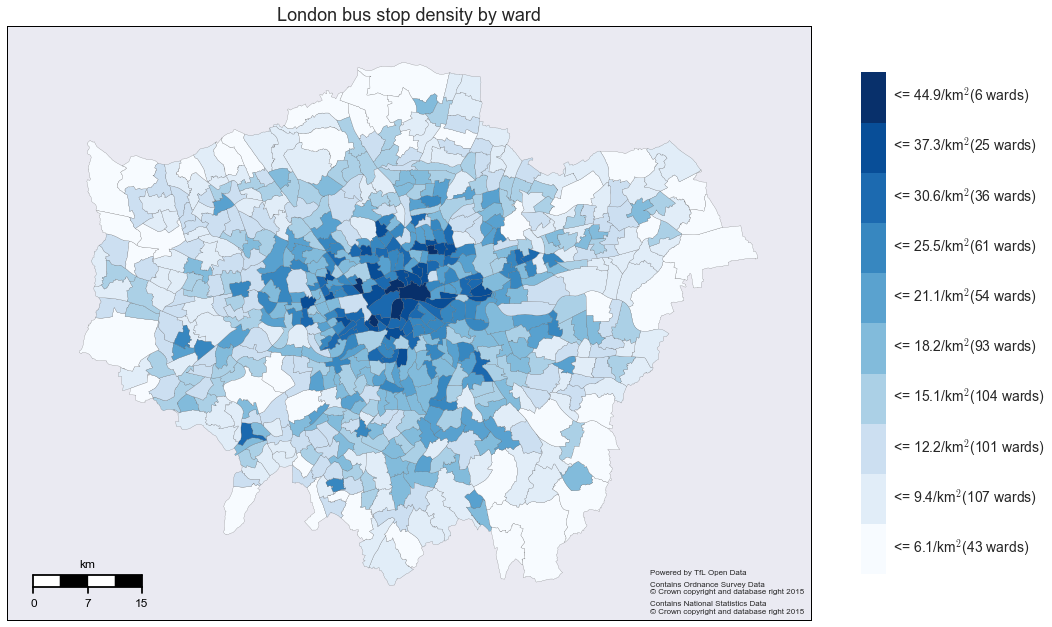

In [101]:
pc = PatchCollection(wards['patches'],match_original=True)

pc.set_facecolor(cmap(wards['jBins'].values/9.))
#pc.set_facecolor(cmap(Normalize(wards['jBins'].values)))

fig = plt.figure()

ax = fig.add_subplot(111)

myMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.6,llcrnrlat=51.27,urcrnrlon=.4,urcrnrlat=51.73)

myMap.drawmapboundary()

ax.add_collection(pc)

cbar = custom_colorbar(cmap, ncolors=len(jLabels)+1, labels=jLabels, shrink=0.5)
cbar.ax.tick_params(labelsize=14)

myMap.drawmapscale(lon=-.5,lat=51.3,lon0=-0.13,lat0=51.51,length=15,barstyle='fancy',fontsize=12)

plt.title('London bus stop density by ward',size=18)

# copyright notices
x,y = myMap(0.2,51.305)
plt.text(x,y,u'Powered by TfL Open Data', size=8)

x,y = myMap(0.2,51.290)
plt.text(x,y,u'Contains Ordnance Survey Data\n© Crown copyright and database right 2015', size=8)

x,y = myMap(0.2,51.275)
plt.text(x,y,u'Contains National Statistics Data\n© Crown copyright and database right 2015', size=8)

#cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
#cb.ax.tick_params(labelsize=6)

plt.show()

In [102]:
# data about the inhabitants
inhab = pd.read_csv('data/inhabitants/ward-mid-year-estimates-sya-since-2002.csv')

# only pick the 2014 estimates
inhab = inhab[inhab['Year'] == 2014]

wardsData = pd.merge(wards,inhab,how='left',left_on='code',right_on='WD12CD')

# assing population fto the City of London
colInhab = inhab[inhab['LAD12NM'] == 'City of London']['all_ages (persons)'].sum()
wardsData.ix[629,'all_ages (persons)'] = colInhab

In [103]:
wardsData['stopsPerInhab'] = wardsData['count']/wardsData['all_ages (persons)']